<img src="./Notes and Reports/Project Description.PNG" alt="Drawing" style="width: 800px;"/>

In [8]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import random
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


size = 18
params = {'legend.fontsize': 'large',
          'figure.figsize': (15,8),
          'axes.labelsize': size * 0.8,
          'axes.titlesize': size * 0.95,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

In [10]:
class DataReader:
    
    def __init__(self):
        pass
    
    def GetStockData(self):
        
        price = yf.download("^STOXX50E", start = "2010-12-01", end = "2020-12-3")['Adj Close'].reset_index()
        return price
    
    def GetLiborData(self, start, end):
        
        libor = pd.read_csv('3-month-libor.csv').fillna(method = 'bfill').fillna(method = 'ffill')

        libor['Date'] = libor['Date'].astype('datetime64[ns]')
        libor = libor.sort_values(by = ['Date'])
        df_train = libor.iloc[-start:-end]
        df_test = libor.iloc[-end:]
        
        '''
        plt.title("historical LIBOR")
        plt.plot(df_train['Date'], df_train['3M'])
        plt.show()
        '''
        
        return df_train, df_test

datareader = DataReader()

In [11]:
class Models():
    
    def __init__(self):
        pass
    
    def zero_coupon(tau, r0, k, drift, sigma):
        
        B = (1 - np.exp(-k * tau)) / k
        A = (drift - sigma ** 2 / (2 * k ** 2)) * (B - tau) - (sigma ** 2 / (4 * k)) * B ** 2

        n2 = len(A)
        A_ = A
        B_ = B

        r_ = np.repeat(r0, n2)

        p = np.exp(A_ - B_ * r_)
        return p
    
    def liborRates(tau, p, mat):
        
        pmat = np.interp(mat, tau, p)
        L = 100 * (1. / pmat - 1) / mat
        return L

    def MleVasicek(self, df, print_params = True):
        
        '''
        Method 1: Using Maximum Likelihood to estimate the parameters of Vasicek Model
        '''
        

        dt = 1.0
        r = np.array(df['3M'])
        a = r[:len(r)-1]
        r = r[1:]

        x = np.array(df['3M'])
        b = x[:len(x)-1]

        s0 = (np.sum(r) - r[-1]) / len(r)
        s1 = np.mean(r)
        s00 = np.sum(a**2) / len(r)
        s01 = np.sum(b*r) / len(r)
        
        drift = (s1*s00 - s0*s01) / ((s0*s1) - (s0**2) + (s00-s01))
        k = np.log((s0-np.mean(x)) / (s1 - np.mean(x)) ) / dt
        beta = 1/k * (1 - np.exp(-k * dt))

        u = np.mean(x)
        m = np.array([])

        for i in range(1,len(x)):
            g = (u * k * beta) + (x[i-1] * (1- (k * beta))) 
            m = np.append(m,g)

        sig = 1/((len(x)*beta)*(1 - k*beta/2)) * np.sum((r - m)**2)
        
        if print_params:
            
            print ("Vasicek Parameter Estimation:")
            print ("k: ", k)
            print ("drift: ", drift)
            print ("sigma: ", sig)
            print ()

        return k, drift, sig
    
    def MleVasicek2(self, df, print_params = True):
        
        '''
        Method 2: 
        '''
        
        r1 = np.array(df['3M'])
        r2 = r1[:len(r1)-1]
        r3 = r1[1:]

        a = len(r1) * np.sum(r2*r3)
        b = np.sum(r3) * np.sum(r2)
        c = len(r1) * np.sum(r2**2)
        d = np.sum(r2) ** 2

        drift = -np.log((a-b)/(c-d))
        k = 1/(len(r1) *(1 - np.exp(-drift))) * (np.sum(r3) - (np.exp(drift)*np.sum(r2) ) )
        variance = (2*drift) /(len(r1) *(1 - np.exp(-2*drift))) * np.square(np.sum(r3 - (r2*np.exp(-drift)) - k*((1 - np.exp(-drift)))))
        beta = drift
        sig = np.sqrt(variance)
        
        if print_params:
            
            print ("k: ", k)
            print ("drift: ", beta)
            print ("sigma: ", sig)
            print ()
        
        return k,beta,sig

    def Vasicek(self, df, r0, K, drift, sigma, T, N, seed):    
        
        random.seed(seed)
        dt = T/float(N)  
        #dt = 1.0
        rates = [r0]
        for i in range(N):
            dr = K*(drift-rates[-1])*dt + sigma*np.random.normal()
            rates.append(rates[-1] + dr)

        rng = pd.date_range(df['Date'].iloc[-1], periods= N + 1 , freq='B')
        lib = pd.DataFrame({ 'Date': rng, '3M': rates}) 

        return lib
    
    def MleGBM(self, price, print_params = True):
        
        '''
        Using Maximum Likelihood to estimate the parameters of GBM Model
        '''
        
        n = len(price['Date'])
        delta = 1
        x_bar = np.sum(np.log(price['Adj Close']/price['Adj Close'].shift(1)))/n
        
        price_bar = np.log(price['Adj Close']/price['Adj Close'].shift(1)) - x_bar
        vol = np.sum(np.power(price_bar, 2))/n
        vol = np.sqrt(vol)
        
        if print_params:
            
            print ("GBM Parameter Estimation")
            print ("MLE for Drift parameter(μ) : " + str(x_bar))
            print ("MLE for Volatility parameter(σ) : " + str(vol))
            
        return x_bar, vol
    
    def Brownian(self, seed, N):
    
        np.random.seed(seed)                         
        dt = 1                                    
        b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  
        W = np.cumsum(b)            
        return W, b

    def GBM(self, seed, price, x_bar, vol): 

        def Simulate(So, mu, sigma, W, T, N):    
            t = np.ones((N + 1))
            S = []
            S.append(So)
            for i in range(1,int(N+1)):

                #drift = (mu - 0.5 * sigma**2) * t[i]
                drift = (mu) * t[i]
                diffusion = sigma * W[i-1]
                S_temp = So*np.exp(drift + diffusion)
                S.append(S_temp)
            return S, t

        N = 252
        So = price['Adj Close'].iloc[-1]
        mu = x_bar
        sigma = vol
     
        T = 1.
        
        n_simulations = 100
        GBM_avg = np.zeros((n_simulations, N))

        for i in range(n_simulations):
            
            W = self.Brownian(seed, N)[0]
            soln = Simulate(So, mu, sigma, W, T, N)[0]    
            soln = soln[:-1]
            GBM_avg[i] = soln
            
        gbm_avg = GBM_avg.mean(axis = 0) 

        rng = pd.date_range('2020-12-4', periods=len(gbm_avg), freq='B')
        price_gbm = pd.DataFrame({ 'Date': rng, 'Close': gbm_avg}) 
        
        return price_gbm

model = Models()

### Get historical STOXX50E data

[*********************100%***********************]  1 of 1 completed


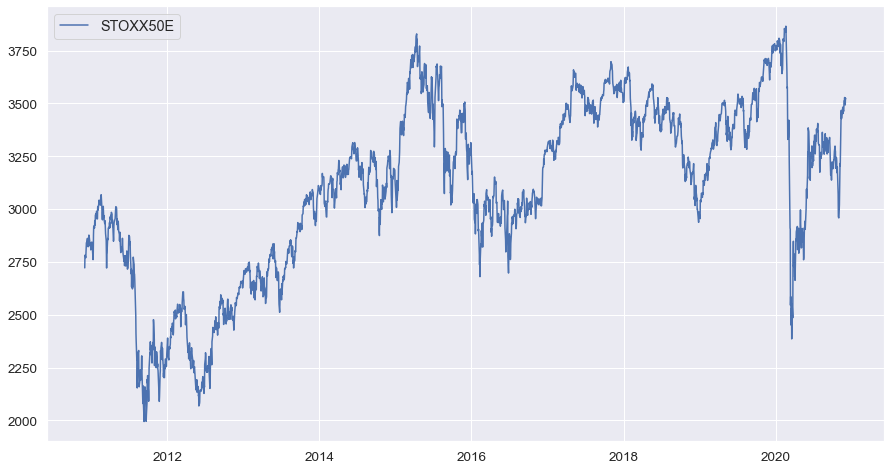

In [12]:
datareader = DataReader()
price = datareader.GetStockData()
plt.plot(price['Date'], price['Adj Close'], label = "STOXX50E")
plt.legend()
plt.show()

### Maximum Likelihood Estimator for callibrating Drift and Volatility of STOXX50E

In [13]:
x_bar, vol = model.MleGBM(price)

GBM Parameter Estimation
MLE for Drift parameter(μ) : 0.0001025554566252467
MLE for Volatility parameter(σ) : 0.013289106196338546


### Simulating Stock Prices as Geometric Brownian Motion with Drift and Volatility using Monte Carlo Simulation

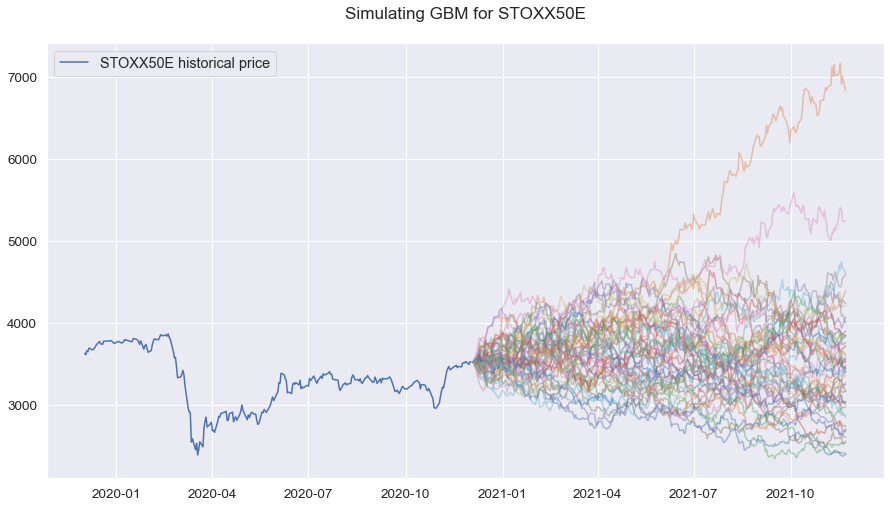

In [34]:
n_simulations = 50

plt.title('Simulating GBM for STOXX50E')
plt.plot(price['Date'][-252:], price['Adj Close'][-252:], label = "STOXX50E historical price")
for i in range(n_simulations):
    
    seed = np.random.randint(1000000)
    price_gbm = model.GBM(seed, price, x_bar, vol)
    plt.plot(price_gbm['Date'], price_gbm['Close'], alpha = 0.45)

plt.legend()
plt.show()

## The Vasicek Model for USD LIBOR rate simulation
dr(t) = k[θ − r(t)]dt + σdW(t)

### Get historical 3-month LIBOR rate

In [14]:
libor_train, libor_test = datareader.GetLiborData(start = 400, end = 1)

### Maximum Likelihood Estimator for callibrating the parameters of Vasicek Model

#### Method 1 (Paper reference 1)

In [15]:
k, drift, sig = model.MleVasicek(libor_train)

Vasicek Parameter Estimation:
k:  0.21374363224455037
drift:  1.5926827884246701
sigma:  0.034832755209362326



#### Method 2 (Paper Reference 2)

In [783]:
k, beta, sig = model.MleVasicek2(libor_train)
k, beta, sig

k:  15.480691352398033
beta:  -0.000345108346025951
sigma:  0.02159096456863789



(15.480691352398033, -0.000345108346025951, 0.02159096456863789)

### Simulating USD Libor rate using Vasicek Model

In [20]:
def vasicekSimulator(datareader, model, n_simulations, test = False):
    
    libor_train, libor_test = datareader.GetLiborData(start = 400, end = 1)
    n_days = 252
    
    if test:
        
        n_days = 90
        libor_train, libor_test = datareader.GetLiborData(start = 400, end = n_days)
        
        plt.title('Simulation Test: Test actual LIBOR curve against Vasicek Model')
        plt.plot(libor_test['Date'], libor_test['3M'], label = "Actual", color = 'r')
        plt.plot(libor_train['Date'], libor_train['3M'], label = "Historical")
    
    else:
        plt.title('Simulation: LIBOR curve using Vasicek Model')
        plt.plot(libor_train['Date'][-252:], libor_train['3M'][-252:], label = "Historical")
    
    k, drift, sig = model.MleVasicek(libor_train)
        
    avg_mse = 0.0
    for i in range(n_simulations):

        seed = np.random.randint(100000)
        libor_pred = model.Vasicek(libor_train, libor_train['3M'].iloc[-1], k, drift, sig, 1, n_days, seed)
        
        #Check model's accuracy
        if test:

            mse = 1/n_days * ((libor_pred['3M'] - libor_test.reset_index()['3M']) ** 2).sum()
            avg_mse += mse
        
        plt.plot(libor_pred['Date'], libor_pred['3M'], alpha = 0.5)
      
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.legend()
    plt.show()
    
    if test:
        avg_mse /= n_simulations
        print ("MSE: ", avg_mse)
    
    return

Vasicek Parameter Estimation:
k:  0.21374363224455037
drift:  1.5926827884246701
sigma:  0.034832755209362326



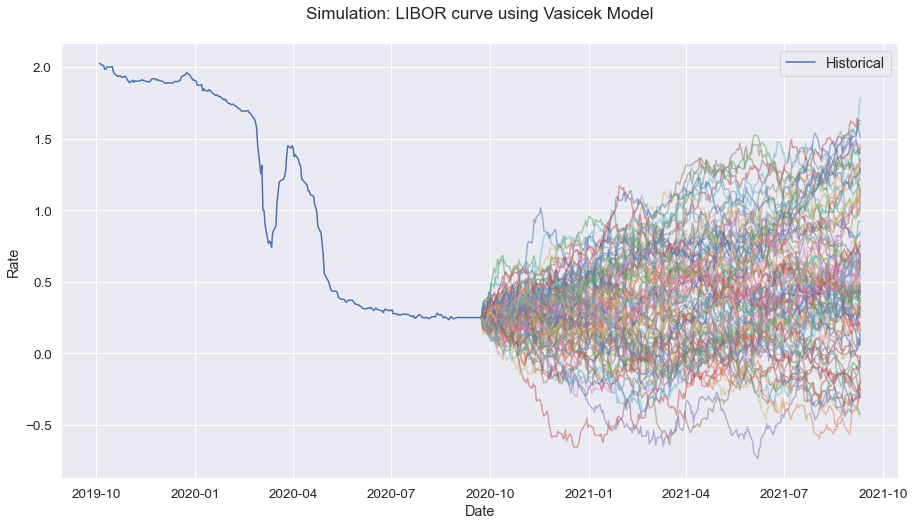

In [21]:
vasicekSimulator(datareader, model, n_simulations = 100, test = False)

### Test few Vasicek Model simulations against actual data

Vasicek Parameter Estimation:
k:  0.4149535468531935
drift:  1.9423389528601858
sigma:  0.06272150028637977



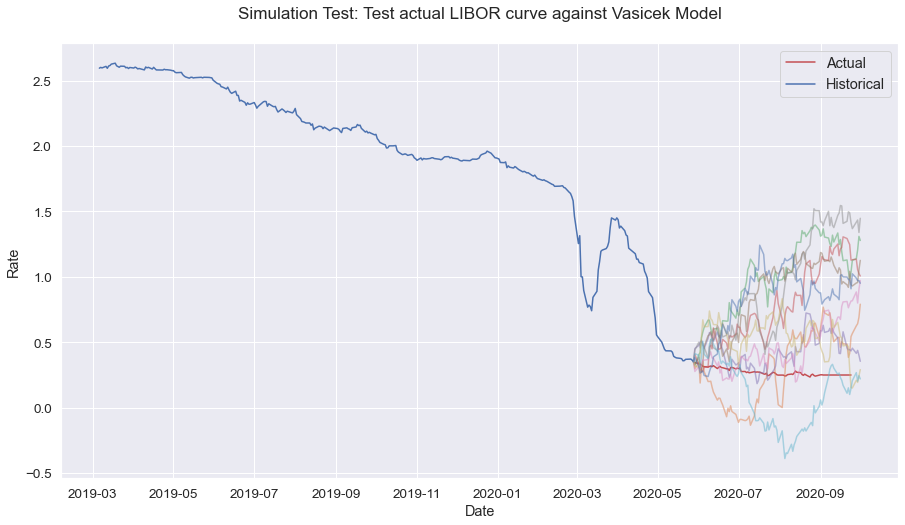

MSE:  0.2748093734269326


In [23]:
vasicekSimulator(datareader, model, n_simulations = 10, test = True)

### Option Pricing 

#### Forward rate

<img src="./Notes and Reports/Forward rate computation.PNG" alt="Drawing" style="width: 800px;"/>

In [193]:
def MonteCarloSimulator(datareader, model, n_simulations, strike_1, strike_2):
    
    libor_train, _ = datareader.GetLiborData(start = 400, end = 1)
    price = datareader.GetStockData()
    
    k, drift, sig = model.MleVasicek(libor_train, print_params = False)
    x_bar, vol = model.MleGBM(price, print_params = False)
    n_days = 252
    
    #Set up Option's parameters
    option_prices = np.zeros((n_simulations))
    index = 0
    T = 252
    #k, k_prime = 1, 1
    delta = 63 
    
    for i in range(n_simulations):

        seed = np.random.randint(1000000)
        
        libor_pred = model.Vasicek(libor_train, libor_train['3M'].iloc[-1], k, drift, sig, 1, n_days, seed)
        price_gbm = model.GBM(seed, price, x_bar, vol)
        
    
        #Compute forward rate and discount factor
        rates = libor_pred['3M']/100.0
        
        #Use daily reinvesting to compute arbitrage free rate(0,t)
        cumulative_rate2 = np.mean(rates)
        cumulative_rate1 = np.mean(rates[:-delta])        
        
        discount_factor1 = 1/(1 + cumulative_rate2)
        discount_factor2 = 1/(1 + cumulative_rate1)
        
        forward_rate1 = T/delta * (discount_factor2/ discount_factor1 - 1)       
        forward_rate2 = rates.iloc[-delta]
        
        
        #print (discount_factor1, forward_rate1)
        #Compute payoff and discounted price of the Option
        ST = price_gbm['Close'].iloc[-1]
        S0 = price_gbm['Close'].iloc[0]
        option_payoff = max(0, (ST/S0 - strike_1) * (forward_rate2/forward_rate1 - strike_2))
        option_price = discount_factor1 * option_payoff
        
        option_prices[index] = option_price
        index += 1
    
    print ("Option Parameters:")
    print ("k: " + str(strike_1) + ", k': " + str(strike_2) + "\n")
    
    print ("Option Price (mean): ", np.mean(option_prices))
    print ("Option Price (standard error): ", np.std(option_prices))
    
    plt.title("Stability check: Option Price vs Simulation")
    plt.plot(range(len(option_prices)), option_prices)
    plt.xlabel("Simulation")
    plt.ylabel("Option Price")
    plt.show()
    

[*********************100%***********************]  1 of 1 completed
Option Parameters:
k: 1.0, k': 1.0

Option Price (mean):  0.4354206317452855
Option Price (standard error):  2.287452691839231


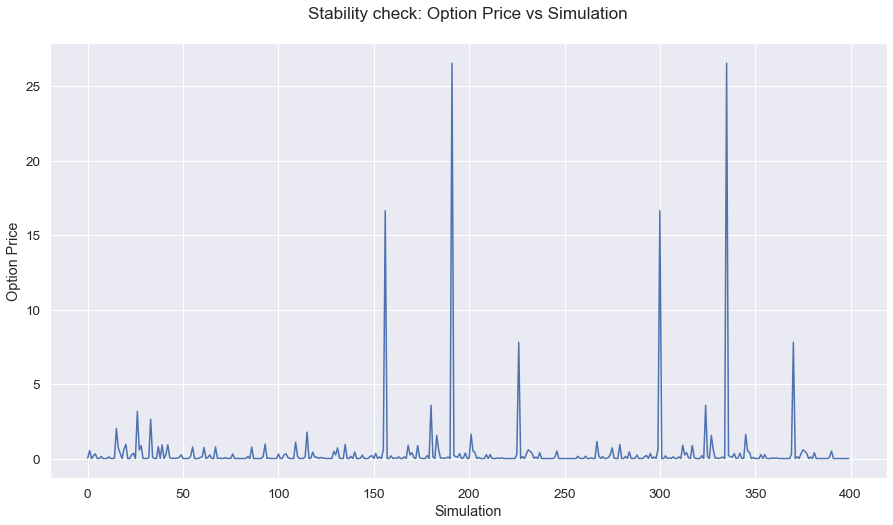

In [194]:
MonteCarloSimulator(datareader, model, 400, 1.0, 1.0)